# 2023 ASD grant MPC surface difference

In [12]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_mask
from brainspace.gradient import GradientMaps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0

# load mask
# fsLR32k_mask = load_mask(join=True)

def load_mpc(File, Ndim):
    """Loads and process a MPC"""

    # load the matrix
    mtx_mpc = nb.load(File).darrays[0].data

    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T

    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)

    return MPC

# Load files
def load_connectomes(files, Ndim, func):
    # Load all the matrices
    M=np.empty([Ndim*2, Ndim*2, len(files)], dtype=float)
    for i, f in enumerate(files):
        M[:,:,i] = func(f, Ndim)

    return M

def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=20, Relax=0.5):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional NUmber of smooth iterations
    Relax  : relax : float, optional relaxation facto
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=mask_c69[0:n2dim]
    Mask_r=mask_c69[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)


# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')


In [6]:
mpc_pna=sorted(glob.glob('sub-PNA*/ses-01/mpc/acq-T1map/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii'))

mpc_pnc=sorted(glob.glob('sub-PNC*/ses-01/mpc/acq-T1map/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii'))
mpc_pna


['sub-PNA001/ses-01/mpc/acq-T1map/sub-PNA001_ses-01_surf-fsLR-5k_desc-intensity_profiles.shape.gii',
 'sub-PNA002/ses-01/mpc/acq-T1map/sub-PNA002_ses-01_surf-fsLR-5k_desc-intensity_profiles.shape.gii',
 'sub-PNA003/ses-01/mpc/acq-T1map/sub-PNA003_ses-01_surf-fsLR-5k_desc-intensity_profiles.shape.gii']

# Subject gradient from intensitites

In [7]:
# get the subject ID
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in mpc_pna]

# Load the intensitites
mpc = nb.load(mpc_pna[0]).darrays[0].data


In [27]:
import scipy.stats
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

In [28]:
mpc_5k = build_mpc(mpc, mask_surf)

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_28513/2608946316.py:22: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


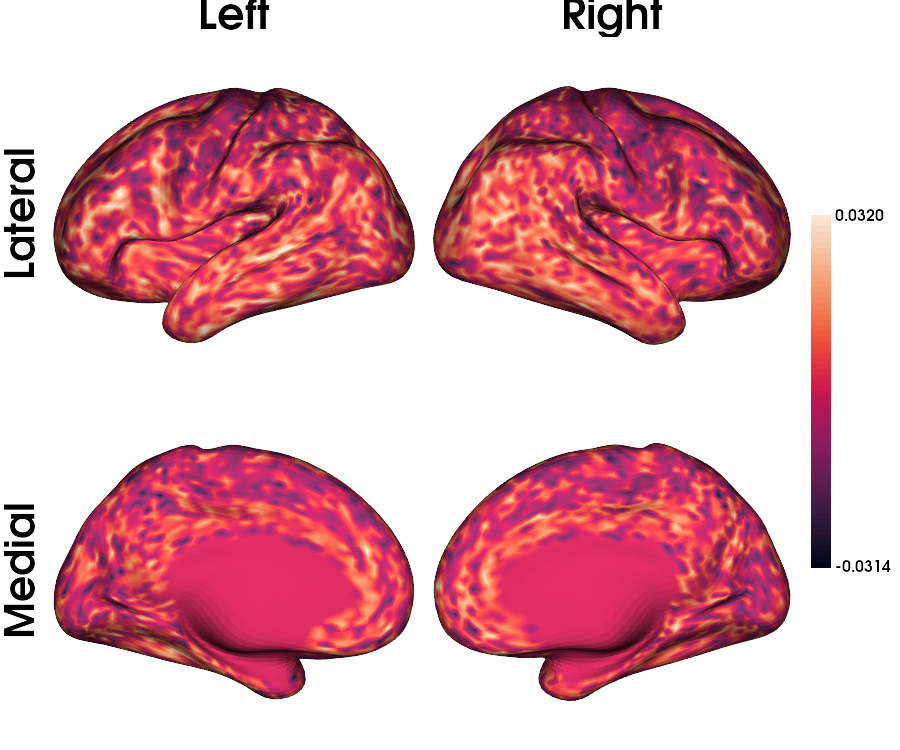

In [29]:
# Calculate the mean over axis=1, excluding NaN values and masked elements
I_M = np.nanmean(np.float32(mpc_5k), axis=1)

plot_hemispheres(inf_lh, inf_rh, array_name=I_M*mask_surf, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid',
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False, offscreen=True)

In [30]:
# Cleanup before diffusion embeding
mpc_5k[~np.isfinite(mpc_5k)] = 0
mpc_5k[np.isnan(mpc_5k)] = 0
mpc_5k[mpc_5k==0] = np.finfo(float).eps

# Get the index of the non medial wall regions
indx = np.where(mask_surf==1)[0]

# Slice the matrix
MPC_masked = mpc_5k[indx, :]
MPC_masked = MPC_masked[:, indx]
MPC_masked.shape

# Calculate the gradients
Ngrad=3
MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
MPCgm.fit(MPC_masked, sparsity=0.9)


GradientMaps(kernel='normalized_angle', n_components=3)

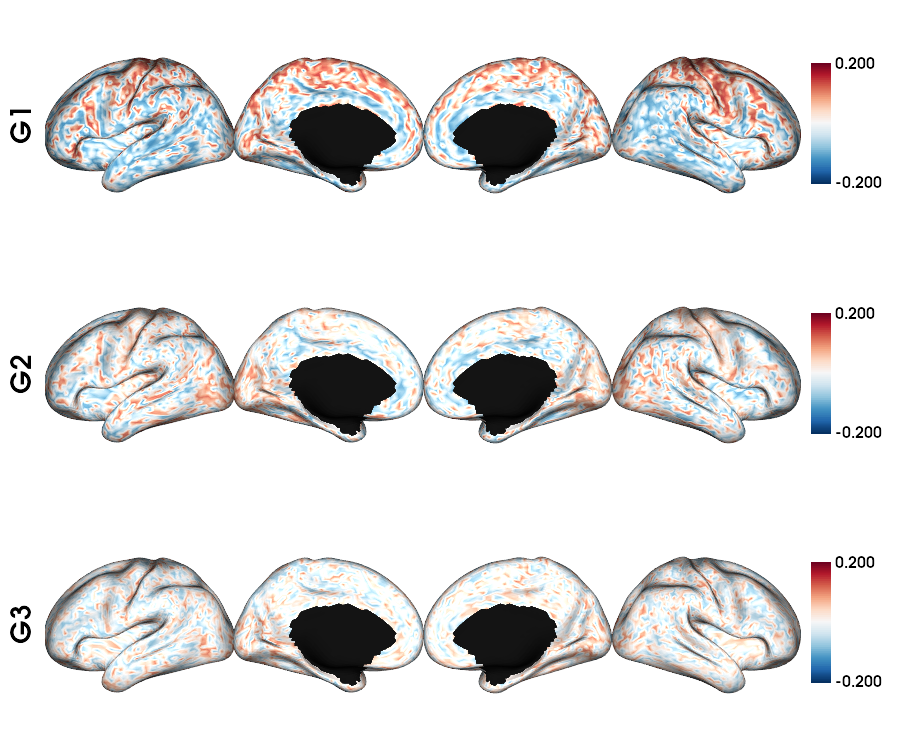

In [33]:
# Map gradients to surface
grad = [None] * Ngrad
for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
    # create a new array filled with NaN values
    g_nan = np.full(mask_surf.shape, np.nan)
    g_nan[indx] = g

    # fill in the calculated values into the corresponding indices of the new array
    #grad[i] = smooth_surf(c5k_lhi, c5k_rhi, g_nan, Niter=3, Relax=0.3)
    grad[i] = g_nan
    
# plot the gradients
Range = (-0.2,0.2)
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range=Range,
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean_HC_.png')

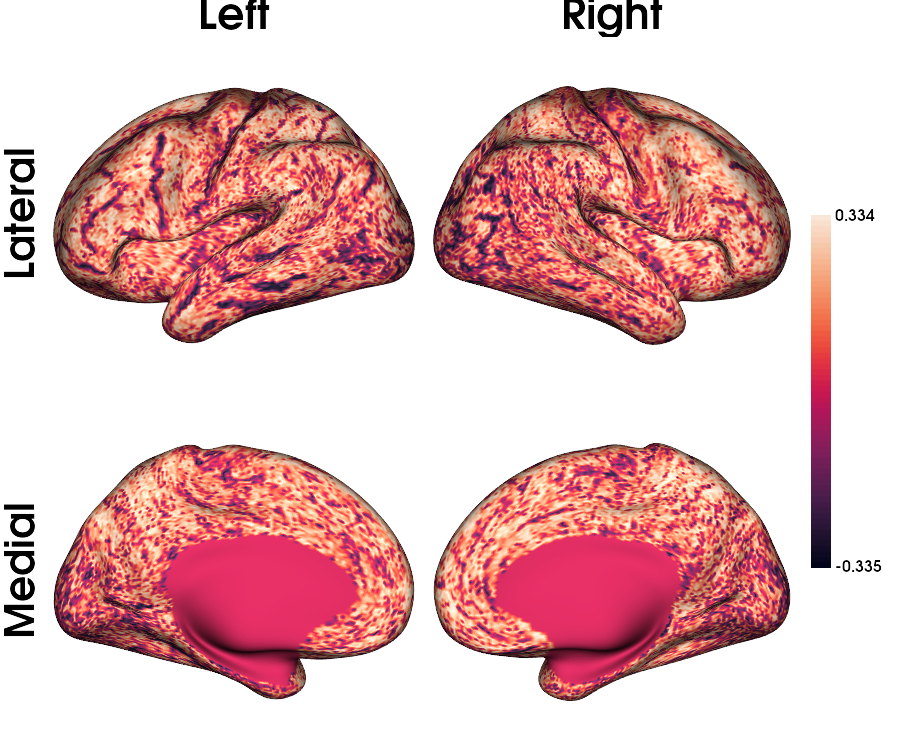

In [91]:

plot_hemispheres(inf_lh, inf_rh, array_name=np.float32(mpc_mean)*fsLR32k_mask, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid',
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False, offscreen=True)

ValueError: Affinity matrix contains NaN or Inf values. Common causes of this include NaNs/Infs or rows of zeros in the input matrix.

In [ ]:
# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in lh_files]

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
        #print(f)
        surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
        
        